Import libraries.

In [33]:
import pgeocode
from shapely.geometry import Point
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

Load in child care location data sets.

In [34]:
toronto_df = pd.read_csv("../child-care-data/toronto_childcare.csv")
york_df = pd.read_csv("../child-care-data/york_childcare.csv")
durham_df = pd.read_csv("../child-care-data/durham_childcare.csv")
peel_df = pd.read_csv("../child-care-data/peel_childcare.csv")

Clean up and normalize child care location data sets. Along with that, remove rename relevant columns and drop unneeded ones.

In [35]:
toronto_df = toronto_df[["LOC_NAME", "ADDRESS", "PCODE"]].rename(columns={"PCODE": "postal_code"})
york_df = york_df[["NAME", "FULL_ADDRESS", "POSTAL_CODE"]].rename(columns={"NAME": "LOC_NAME", "FULL_ADDRESS": "ADDRESS", "POSTAL_CODE": "postal_code"})
durham_df = durham_df[["NAME", "ADDRESS", "POSTAL_CODE"]].rename(columns={"POSTAL_CODE": "postal_code"})
peel_df = peel_df[["LM_NAME", "STR_ADDR", "POSTAL"]].rename(columns={"LM_NAME": "LOC_NAME", "STR_ADDR": "ADDRESS", "POSTAL": "postal_code"})


Conbine all cleaned and normalized child care location data sets into one data frame.

In [36]:
all_childcare = pd.concat([toronto_df, york_df, durham_df, peel_df], ignore_index=True)
all_childcare

,LOC_NAME,ADDRESS,postal_code,NAME
0,Lakeshore Community Child Care Centre,101 SEVENTH ST,M8V 3B5,NaN
1,Alternative Primary School Parent Group,1100 SPADINA RD,M5N 2M6,NaN
2,Cardinal Leger Child Care Centre (Scarborough),600 MORRISH RD,M1C 4Y1,NaN
3,George Brown - Richmond Adelaide Childcare Centre,130 ADELAIDE ST W,M5H 3P5,NaN
4,Woodland Nursery School (Warden Woods Communit...,1 FIRVALLEY CRT,M1L 1N8,NaN
...,...,...,...,...
2580,House of Wonder Early Learning Centre,2101 Dixie Rd,L4Y1Z1,NaN
2581,Maplewood Academy,3580 Thomas St,L5M2S6,NaN
2582,Hakuna Matata Child Care Centre Inc.,5650 Montevideo Rd,L5N4E4,NaN
2583,Lullaboo Childcare Center - Wanless,760 Wanless Dr,L7A0A9,NaN


Geocode child care location data. Each postal code is sent through pgeocode, which returns coordinates.After, geo_data becomes a dataframe with latitude and longitude columns. Adds the lat/lon to the main dataframe.

In [37]:
nomi = pgeocode.Nominatim('ca')
geo_data = all_childcare['postal_code'].apply(nomi.query_postal_code)
all_childcare["latitude"] = geo_data["latitude"]
all_childcare["longitude"] = geo_data["longitude"]
childcare_all = all_childcare.dropna(subset=["latitude", "longitude"])

Creates Point geometry objects from lat/lon pairs. Converts the regular DataFrame to a GeoDataFrame so it can be used with maps. Uses CRS (Coordinate Reference System) EPSG:4326, which is standard lat/lon.

In [38]:
geometry = [Point(xy) for xy in zip(childcare_all["longitude"], childcare_all["latitude"])]
childcare_gdf = gpd.GeoDataFrame(childcare_all, geometry=geometry, crs="EPSG:4326")

Loads the shapefile of GTA Census Subdivisions (CSDs) and performs a spatial join: keeps child care points that fall within a CSD polygon. Merges CSD info into each child care point based on location

In [39]:
csd_gdf = gpd.read_file("../boundaries-data/census_subdivision_boundary.shp").to_crs("EPSG:4326")
joined = gpd.sjoin(childcare_gdf, csd_gdf, how="inner", predicate="within")

Groups by CSD name. Counts how many child care centres fall in each subdivision

In [40]:
group_column = "CSDNAME" if "CSDNAME" in joined.columns else joined.columns[0]
access_counts = joined.groupby(group_column).size().reset_index(name="child_care_centres")
access_counts = access_counts.sort_values(by="child_care_centres", ascending=False)
access_counts

,CSDNAME,child_care_centres
23,Toronto,1073
16,Mississauga,290
5,Brampton,203
25,Vaughan,184
15,Markham,162
21,Richmond Hill,101
26,Whitby,71
19,Oshawa,63
0,Ajax,58
18,Newmarket,55


Plot data.

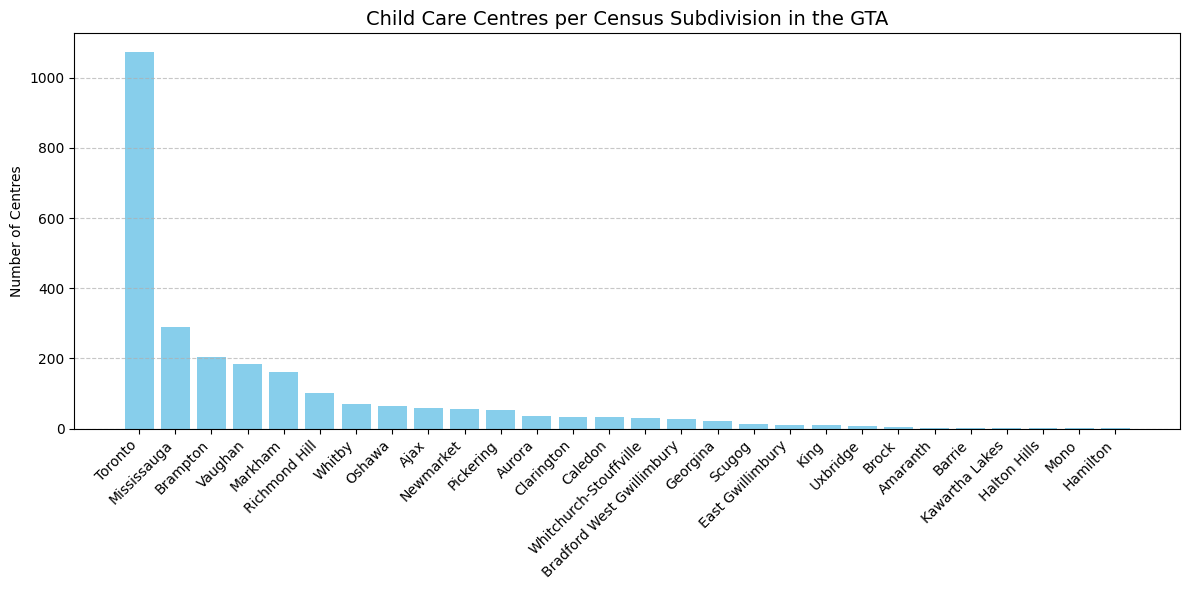

In [41]:
plt.figure(figsize=(12, 6))
plt.bar(access_counts[group_column], access_counts["child_care_centres"], color="skyblue")
plt.title("Child Care Centres per Census Subdivision in the GTA", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Number of Centres")
plt.tight_layout()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()